In [34]:
import numpy as np
import glob
import pickle
import cv2 as cv
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

In [8]:
classes = {
    "without_mask": 0,
    "with_mask": 1,
    "mask_worn_incorrect": 2
}

In [143]:
def load_dataset(label, labels = classes):
    paths = glob.glob("./face-mask-dataset/"  + label + "/*")
    paths.sort()
    return [np.array(cv.imread(p)) for p in paths], [labels[label] for p in paths]

def load_gray_dataset(label, labels = classes):
    paths = glob.glob("./face-mask-dataset/"  + label + "/*")
    paths.sort()
    return [np.array(cv.cvtColor(cv.imread(p), cv.COLOR_BGR2GRAY)) for p in paths], [labels[label] for p in paths]

def load_images_rgb(path):
    paths = glob.glob(path + "/*")
    paths.sort()
    return [np.array(cv.imread(p)) for p in paths]

def load_images(path):
    paths = glob.glob(path + "/*")
    paths.sort()
    return [np.array(cv.cvtColor(cv.imread(p), cv.COLOR_BGR2GRAY)) for p in paths]

def extract_hog(image, ppc = 16):
    features, _ = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    return features

In [118]:
mask, mask_labels = load_gray_dataset("with_mask")
no_mask, no_mask_labels = load_gray_dataset("without_mask")
mask_incorrect, mask_incorrect_labels = load_gray_dataset("mask_worn_incorrect")

print(len(mask), len(mask_labels))
print(len(no_mask), len(no_mask_labels))
print(len(mask_incorrect), len(mask_incorrect_labels))

images = np.concatenate((mask, no_mask, mask_incorrect))
labels = np.concatenate((mask_labels, no_mask_labels, mask_incorrect_labels))
print(len(images), len(labels))

for i in images:
    assert(i.shape == (128, 128))

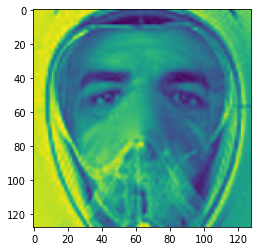

In [23]:
plt.imshow(mask[0]);

In [124]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.75, shuffle=True)

In [125]:
hog_train = [extract_hog(image) for image in x_train]

In [43]:
model = svm.SVC()
parameters = [{
    "C": [0.1, 1, 10],
    "kernel": ["poly"],
    "degree": [2, 3, 4, 5],
    "gamma": [0.05, 0.025]
}, {
    "C": [0.1, 1, 10],
    "kernel": ["rbf"],
    "gamma": [0.05, 0.025]
}]
n_folds = 3
grid_search_cv = GridSearchCV(model, parameters, cv=n_folds)

grid_search_cv.fit(hog_train, y_train)
print(grid_search_cv.best_params_)

{'C': 10, 'degree': 3, 'gamma': 0.025, 'kernel': 'poly'}


In [126]:
clf = svm.SVC(C=10, degree=3, gamma=0.025, kernel="poly")
clf.fit(hog_train, y_train)

SVC(C=10, gamma=0.025, kernel='poly')

In [127]:
hog_test = [extract_hog(image) for image in x_test]
clf.score(hog_test, y_test)

0.9807102148180622

In [61]:
filename = "SVC-model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

In [5]:
filename = "SVC-model.pkl"
with open(filename, 'rb') as file:
    clf = pickle.load(file)

In [144]:
faces = load_images_rgb("faces")
resized_faces = [cv.resize(f, (128, 128), interpolation=cv.INTER_CUBIC) for f in faces]

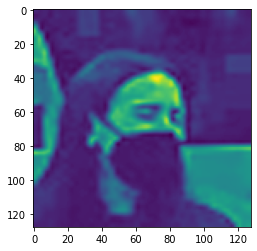

In [12]:
plt.imshow(resized_faces[2]);

In [15]:
hog_faces = [extract_hog(f) for f in resized_faces]
print(clf.score(hog_faces,  [1 for i in range(len(faces))]))
results = clf.predict(hog_faces)

In [30]:
print([e for e in zip([i for i, c in enumerate(results) if c != 1],
    [c for c in results if c != 1])])

[(10, 0), (15, 0), (18, 0), (21, 2), (25, 0), (28, 0), (48, 0), (51, 0), (124, 0), (127, 0), (131, 0)]


In [133]:
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [134]:
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

maxpool = tf.keras.layers.GlobalMaxPooling2D()(mobilenet.output)
output = tf.keras.layers.Dense(3, activation='softmax')(maxpool)
model = tf.keras.Model(inputs=[mobilenet.input], outputs=[output])
for layer in model.layers[:-23]:
    layer.trainable = False

In [135]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [90]:
mask, mask_labels = load_dataset("with_mask")
no_mask, no_mask_labels = load_dataset("without_mask")
mask_incorrect, mask_incorrect_labels = load_dataset("mask_worn_incorrect")

print(len(mask), len(mask_labels))
print(len(no_mask), len(no_mask_labels))
print(len(mask_incorrect), len(mask_incorrect_labels))

one_hot_encoding = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}

images = np.concatenate((mask, no_mask, mask_incorrect))
labels = np.concatenate((mask_labels, no_mask_labels, mask_incorrect_labels))
labels = np.array([one_hot_encoding[i] for i in labels])
images = np.array([cv.resize(i, (224, 224)) for i in images])
images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
print(len(images), len(labels))
for i in images:
    assert(i.shape == (224, 224, 3))

In [125]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, train_size=0.8, shuffle=True)

In [137]:
model.fit(x=x_train,
            y=y_train,
            validation_split=0.2,
            epochs=50
)

Epoch 1/50
180/180 [==============================] - 147s 818ms/step - loss: 0.6181 - accuracy: 0.8119 - val_loss: 0.6099 - val_accuracy: 0.8232
Epoch 2/50
180/180 [==============================] - 133s 738ms/step - loss: 0.1429 - accuracy: 0.9502 - val_loss: 0.3886 - val_accuracy: 0.8817
Epoch 3/50
180/180 [==============================] - 133s 741ms/step - loss: 0.0800 - accuracy: 0.9715 - val_loss: 0.2376 - val_accuracy: 0.9276
Epoch 4/50
180/180 [==============================] - 132s 735ms/step - loss: 0.0504 - accuracy: 0.9821 - val_loss: 0.1958 - val_accuracy: 0.9415
Epoch 5/50
180/180 [==============================] - 132s 735ms/step - loss: 0.0373 - accuracy: 0.9873 - val_loss: 0.1490 - val_accuracy: 0.9513
Epoch 6/50
180/180 [==============================] - 129s 714ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.1283 - val_accuracy: 0.9589
Epoch 7/50
180/180 [==============================] - 125s 695ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0966 -

In [152]:
model.save("mobilenet-face-mask-detection-model")

2022-02-12 00:41:36.930142: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mobilenet-model/assets


In [145]:
faces = load_images_rgb("faces")
faces = np.array([cv.resize(f, (224, 224)) for f in faces])
faces = tf.keras.applications.mobilenet_v2.preprocess_input(faces)


In [150]:
model.evaluate(faces, np.array([(0, 1, 0) for i in range(len(faces))]))

5/5 [==============================] - 2s 352ms/step - loss: 0.0092 - accuracy: 1.0000


[0.009233017452061176, 1.0]

In [151]:
model.evaluate(x_test, y_test)

57/57 [==============================] - 28s 495ms/step - loss: 0.0415 - accuracy: 0.9905


[0.04154375568032265, 0.9905397891998291]

In [153]:
loaded = tf.keras.models.load_model("mobilenet-face-mask-detection-model")

In [154]:
loaded.evaluate(x_test, y_test)

57/57 [==============================] - 28s 494ms/step - loss: 0.0415 - accuracy: 0.9905


[0.04154375568032265, 0.9905397891998291]